# ELE 435-535 Computational Lab 2

### Due Date: 10/01/2018 (Monday) 11:30 PM
### Name: 

### Import required Python packages

In [2]:
# Import additional packages if needed
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as io

%matplotlib inline

### YALE B Dataset

You will use the YALE B face dataset to explore face recognition by classifying face images. The Yale B dataset contains frontal face images (size 192 x 168) of 38 subjects, with around 64 images per subject (not all subjects have the same number of images). The total number of images is 2,414. The images have been column-wise vectorized into 192 x 168 = 32,256 column vectors and these are stored as the columns of a matrix X. The corresponding 2,414 labels, ranging rom 1 to 39 (no 14), are provided in a row vector Y. For background and additional reading, refer to http://research.microsoft.com/pubs/132810/PAMI-Face.pdf.

### Display Some Images

In [3]:
# This cell is given. You do not need to modify.

# Functions to represent the image in matrix or column vector
def packcw(A):
    return (A.T).reshape(-1,1)

def unpackcw(x,nr):
    return x.reshape(-1,nr).T

1) Load the YALEBXF.mat face data and display the first image of 38 subjects on a 5 x 8 tile. (This part is done as an example) 

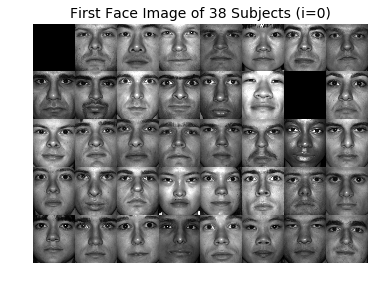

In [4]:
# This cell is given. You do not need to modify.
# You can reference this code for other questions below but just mention where you got it from.

# Load the YALE B database
YALE = io.loadmat('YALEBXF.mat') 
X = YALE['X']
Y = YALE['Y']
nr, nc = 192, 168 # height = 192, width = 168
dim = nr * nc     # dimension = 32256
nex = X.shape[1]  # Total number of examples = 2414

nFc = 40          # Total number of faces
nImg = np.zeros(nFc) # Numper of examples for each person
for i in range(nFc):
    nImg[i] = (Y==i).sum()
    
# Show the faces
# Make face board of 38 faces
faceIdx = 0 # index of face to display for each subject
Bh, Bw = 5, 8
FB = np.zeros((Bh*nr, Bw*nc))
for i in range(nFc):
    if nImg[i]>0:
        loc = np.where(Y==i)[1]
        x = X[:,loc[faceIdx]]
        A = unpackcw(x,nr)
        row, col = divmod(i,Bw)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (6,6))
plt.imshow(FB, cmap='gray')
plt.axis('off')
plt.title("First Face Image of 38 Subjects (i=%i)" %faceIdx, fontsize=14)
plt.show()

2) Compute the mean of all faces. Then center the dataset. 

In [5]:
# Center the dataset
mean = np.mean(X)
centered = X - mean

### Singular Value Decomposition

3) Compute SVD on the centered data (You can use the svd function).

Note: Since the data set is large, it might take some time so do it once then save each variable so you can simply load the results again when needed.

In [6]:
u, s, v = np.linalg.svd(centered)

3) Plot the top 200 variances (squares of the singular values) in order from largest to smallest and the cumulative sum of those variances. Use the functions A.sum() and A.cumsum() Where does the difference in variances start to become less significant? Mark the point as a vertical dashed line. At what index do you capture 95% of the total variance? Mark that as a second vertical line.

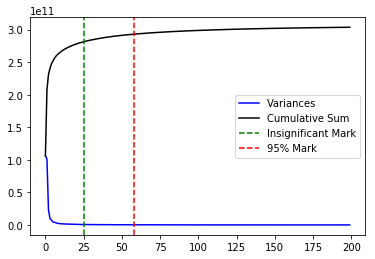

In [7]:
variances = np.array([x**2 for x in s])
mark = np.where(variances.cumsum() > 0.95*variances.sum())[0][0]

plt.plot(variances[0:200], label='Variances', color='blue')
plt.plot(variances[0:200].cumsum(), label='Cumulative Sum', color='black')
plt.axvline(x=25, label='Insignificant Mark', linestyle='--', color='green')
plt.axvline(x=mark, label='95% Mark', linestyle='--', color='red')
plt.legend()

4) Compute the projection of data onto the first $d$ principal components for $d = 8,16,32,64,128,256$.

In [8]:
num_components = [8, 16, 32, 64, 128, 256]
projections = []

for d in num_components:
    projections.append(np.matmul(np.matmul(u[:,0:d], np.diag(s[0:d])),v[0:d,:]))

5) Approximate the original image from the projected data onto first $d$ principal components for $d = 8,16,32,64,128,256$. Then, display the approximate faces for the same images from 1) in a 5 x 8 tile. Remember to add back the mean before displaying the image.

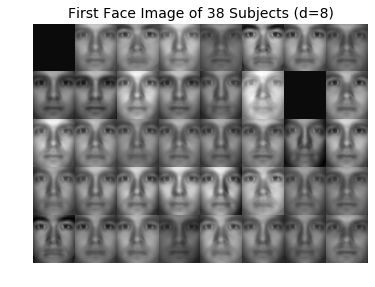

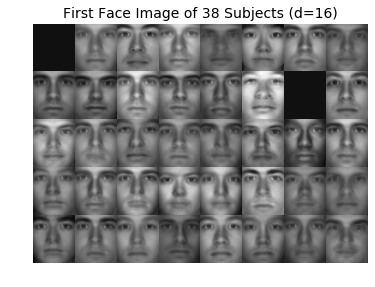

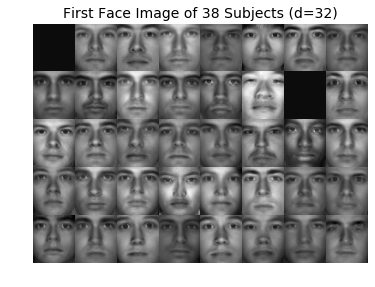

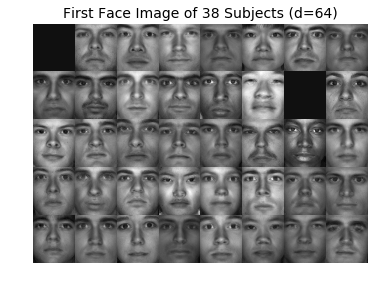

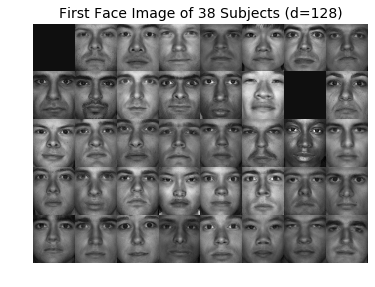

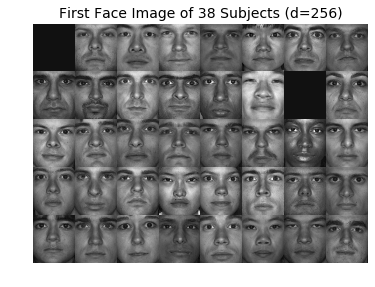

In [9]:
for d, projection in zip(num_components, projections):
    FB = np.zeros((Bh*nr, Bw*nc))
    for i in range(nFc):
        if nImg[i]>0:
            loc = np.where(Y==i)[1]
            x = projection[:,loc[faceIdx]]
            A = unpackcw(x,nr)
            row, col = divmod(i,Bw)
            rpt, cpt = row*nr, col*nc
            FB[rpt:rpt+nr, cpt:cpt+nc] = A + mean
        
    plt.figure(figsize = (6,6))
    plt.imshow(FB, cmap='gray')
    plt.axis('off')
    plt.title("First Face Image of 38 Subjects (d=%i)" %d, fontsize=14)
    plt.show()

### Nearest Neighbor Classifier

Use the first 50 images of each subject as a training data and rest of the images as a test data. Please note that total number of images for each subject is different.

6) Write functions to implement nearest neighbor classifier to classify the faces on the test data and report the accuracy. 

In [10]:
def split_data(X, Y):
    train_x, train_y = [], []
    test_x, test_y = [], []

    for i in range(nFc):

        if nImg[i]>0:
            loc = np.where(Y==i)[1]

            for j in range(len(loc)):
                if j < 40:
                    train_x.append(X[:,loc[j]])
                    train_y.append(Y[:,loc[j]])
                else:
                    test_x.append(X[:, loc[j]])
                    test_y.append(Y[:, loc[j]])
                    
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)
        
def classify(train_x, train_y, test_x, test_y):
    num_correct = 0

    for x, y in zip(test_x, test_y):
        pred_label = 0
        distance = np.linalg.norm(x - train_x[0, :])

        for neighbor, label in zip(train_x, train_y):
            if np.linalg.norm(x - neighbor) < distance:
                pred_label = label
                distance = np.linalg.norm(x - neighbor)
                
        if pred_label == y:
            num_correct += 1
    
    return num_correct/len(test_y)

train_x, train_y, test_x, test_y = split_data(centered, Y)
accuracy = classify(train_x, train_y, test_x, test_y)
print('Accuracy on test set is: ' + str(accuracy))

Accuracy on test set is: 0.35570469798657717


7) Apply nearest neighbor classifier for the data projected on $d$ principal components for $d = 8,16,32,64,128,256$. Plot the dimension vs. accuracy graph. How does the dimension affect the accuracy of the classification?

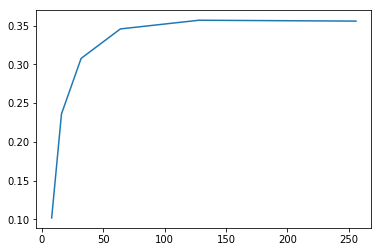

In [12]:
# Was not sure if I was supposed to re-split the data according to the projections or use the testset from above.
accuracies = []

for projection in projections:
    train_x, train_y, test_x, test_y = split_data(projection, Y)
    accuracies.append(classify(train_x, train_y, test_x, test_y))

plt.plot(num_components, accuracies)

# It saturates pretty quickly to the accuracy above